In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z

from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.quantum_info import Statevector

from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
def createEqSuperposQuaternion():
    temp = QuantumCircuit(3)
    temp.h(0)
    temp.h(1)
    temp.h(2)
    return temp

In [3]:
#backend = Aer.get_backend('statevector_simulator')
#result = execute(createEqSuperposQuaternion().reverse_bits(), backend).result().get_statevector()
#print(result)

In [4]:
mix = QuantumCircuit(1)
mix.rx(np.pi, 0)
mix.draw()

┌───────┐
q_0: ┤ Rx(π) ├
     └───────┘

In [5]:
miy = QuantumCircuit(1)
miy.ry(np.pi, 0)
miy.draw()

┌───────┐
q_0: ┤ Ry(π) ├
     └───────┘

In [6]:
miz = QuantumCircuit(1)
miz.rz(np.pi, 0)
miz.draw()

┌───────┐
q_0: ┤ Rz(π) ├
     └───────┘

In [7]:
mi = QuantumCircuit(1)
mi.rz(2*np.pi, 0)
mi.draw()

┌────────┐
q_0: ┤ Rz(2π) ├
     └────────┘

In [45]:
#Unitary to create state \rho
size = 4
state = QuantumCircuit(size)

state.h(0)
state.h(1)
state.cx(0, 2)
state.cx(1, 3)

state.draw()

┌───┐          
q_0: ┤ H ├──■───────
     ├───┤  │       
q_1: ┤ H ├──┼────■──
     └───┘┌─┴─┐  │  
q_2: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_3: ──────────┤ X ├
               └───┘

In [46]:
def createQuantumCircuit():
    circ = QuantumCircuit(7)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperposQuaternion()
    circ.append(superPosCircuit, [0, 1, 2])
    circ.append(state, [3, 4, 5, 6])

    custom = miz.to_gate().control(2)
    circ.append(custom, [0, 3, 4])
    
    custom = miy.to_gate().control(2)
    circ.append(custom, [1, 3, 4])

    custom = mix.to_gate().control(2)
    circ.append(custom, [2, 3, 4])

    circ.x(0)
    custom = mi.to_gate().control(3)
    circ.append(custom, [0, 2, 3, 4])
    circ.x(0)
    
    circ.append(superPosCircuit.inverse(), [0, 1, 2])

    return circ

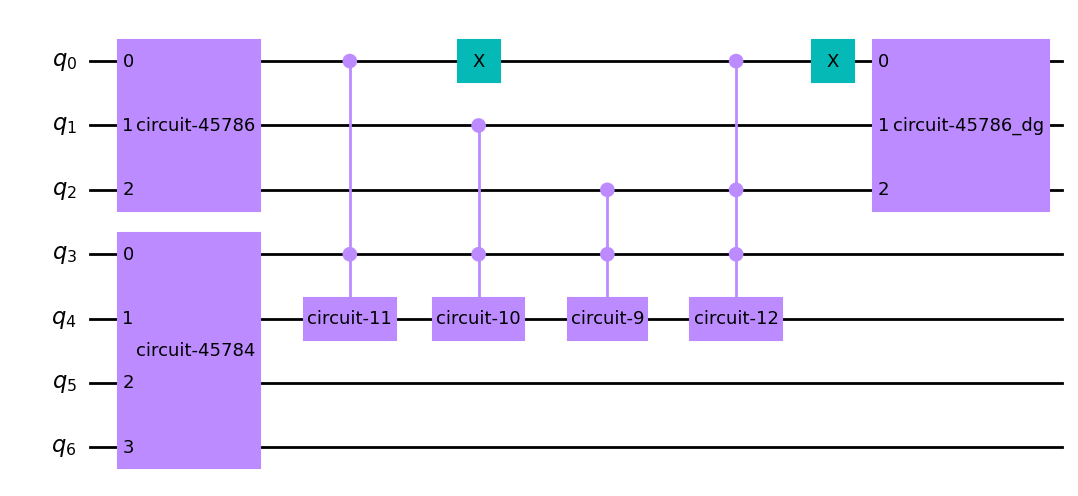

In [47]:
qCirc = createQuantumCircuit()
qCirc.draw('mpl')

In [48]:
#Create Hamiltonian here
hamiltonian = I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [49]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [50]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation. 
'''
#Replace the provider with your personal credentials for hub, group and main
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")

noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [51]:
def costf(noisy = False):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    
    if noisy:
        result = noisy_sampler.convert(expectation).eval()  
    else:
        result = noiseless_sampler.convert(expectation).eval()  
    
    return np.real(result)

In [55]:
print("Initial Cost : ", costf(True))

Initial Cost :  0.3841505344554686
